In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, losses, metrics
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

2024-08-10 20:02:24.690119: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def get_X(datasets_file: str, sample_length: int):
    with open(datasets_file, "r") as file:
        records = [line.rstrip().split() for line in file]
    X = []
    for line in records:
        n = len(line)
        if n >= sample_length:
            # print(line)
            for i in range(0, n - sample_length + 1, 2):
                # print(f"--> i={i} : {line[i : i + sample_length]}")
                X.append(
                    np.array(
                        [float(f"{float(x):.4f}") for x in line[i : i + sample_length]]
                    )
                )
        # else:
        #     x = line[0]
        #     X.append(np.array([np.float32(x), np.float32(np.random.uniform(1.0, 4.0)), np.float32(x)]))
    X = np.vstack(X)
    return X

In [3]:
def get_y(X, y_correct):
    return np.full(X.shape[0], y_correct, dtype=int).reshape(-1, 1)

In [4]:
sample_length = 3

In [5]:
X = get_X("datasets.txt", sample_length)
X.shape

(101849, 3)

In [6]:
X

array([[1.0400e+04, 1.6660e-01, 1.1600e+04],
       [1.1600e+04, 1.0763e+00, 1.1100e+04],
       [1.1100e+04, 1.7700e-01, 1.1200e+04],
       ...,
       [1.0700e+04, 1.5140e-01, 1.0900e+04],
       [1.0900e+04, 2.3430e-01, 1.2100e+04],
       [1.2100e+04, 1.8200e-01, 1.0600e+04]])

In [7]:
y = get_y(X, 0)
y.shape

(101849, 1)

In [8]:
y

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [9]:
X_bad = get_X("datasets_bad_article.txt", sample_length)
X_bad.shape

(97978, 3)

In [10]:
y_bad = get_y(X_bad, 1)
y_bad.shape

(97978, 1)

In [11]:
X = np.vstack(tup=(X, X_bad))
X.shape

(199827, 3)

In [12]:
y = np.vstack(tup=(y, y_bad))
y.shape

(199827, 1)

In [14]:
y = y.reshape(-1,)
y.shape

(199827,)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42
)

In [14]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(159861, 3) (159861, 1) (39966, 3) (39966, 1)


In [16]:
# Создание модели
def create_model(input_dim):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(input_dim,)))
    model.add(tf.keras.layers.Dense(128, activation="relu"))
    # model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


# Создание модели
model = create_model(X_train.shape[1])

# Коллбэки
early_stop = callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True, mode="max", verbose=1
)
checkpoints = callbacks.ModelCheckpoint(
    filepath="./article_models/_{val_accuracy:.6f}.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1,
)
# Обучение модели
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.3,
    callbacks=[early_stop, checkpoints],
    verbose=1,
)

# Оценка модели на тестовой выборке
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/50
854/875 [============================>.] - ETA: 0s - loss: 71.8756 - accuracy: 0.5066
Epoch 1: val_accuracy improved from -inf to 0.49242, saving model to ./article_models/_0.492421.h5
875/875 [==============================] - 4s 4ms/step - loss: 70.7831 - accuracy: 0.5065 - val_loss: 31.8562 - val_accuracy: 0.4924
Epoch 2/50
875/875 [==============================] - ETA: 0s - loss: 37.8167 - accuracy: 0.5050
Epoch 2: val_accuracy improved from 0.49242 to 0.53396, saving model to ./article_models/_0.533956.h5
875/875 [==============================] - 5s 5ms/step - loss: 37.8167 - accuracy: 0.5050 - val_loss: 19.2326 - val_accuracy: 0.5340
Epoch 3/50
870/875 [============================>.] - ETA: 0s - loss: 34.2386 - accuracy: 0.5090
Epoch 3: val_accuracy did not improve from 0.53396
875/875 [==============================] - 3s 4ms/step - loss: 34.2113 - accuracy: 0.5088 - val_loss: 15.5052 - val_accuracy: 0.5118
Epoch 4/50
856/875 [============================>.] - ETA:

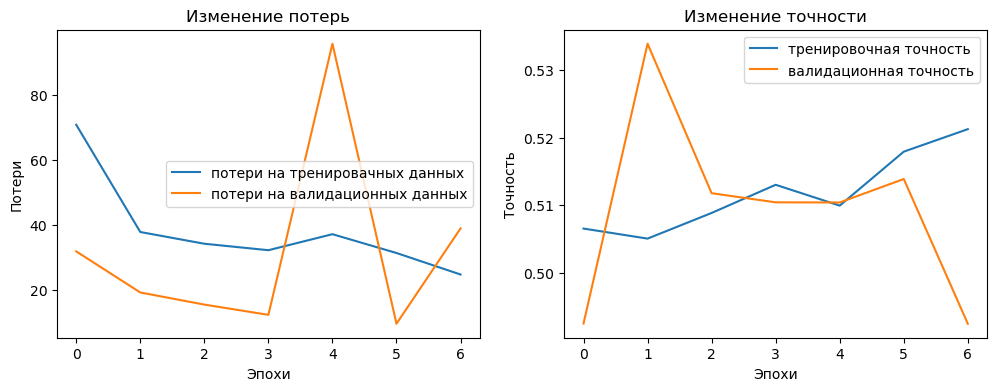

In [17]:
# Сохранение кривых обучения и точности
plt.figure(figsize=(12, 4))

# Кривая потерь
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="потери на тренировачных данных")
plt.plot(history.history["val_loss"], label="потери на валидационных данных")
plt.title("Изменение потерь")
plt.xlabel("Эпохи")
plt.ylabel("Потери")
plt.legend()

# Кривая точности
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="тренировочная точность")
plt.plot(history.history["val_accuracy"], label="валидационная точность")
plt.title("Изменение точности")
plt.xlabel("Эпохи")
plt.ylabel("Точность")
plt.legend()

acc = history.history["val_accuracy"][-1]
plt.savefig(f"training_curves_{acc}.png")
plt.show()